This code implements basic descriptive analysis of X-line buses 
Stavanger-region using Kolumbus data. It also shows how to use these
data, fixing common data issues.

I will clean the data beyond what is necessary just for this particular analysis. This of course makes it slower at this moment, but provides an easier starting pointing for further work. Moreoever, my goal was not to use a any loops, for which I had two reasons. First, it makes code more "pythonic" and I simply saw it as a challange on its own. 

Second, code which avoids loops is later easier to parallelize, what might be ultimately necessary to get reasonable processing time for more complex analysis and full data scale. As a reference point cleaning and analysis presented here, using 1.5 months of data on a 3.7GHz Xeon processor with 12GB RAM and SSD storage takes around 30 mins. This could of course be accelerated through many perfromance improvements here and there, but they would obfuscate functionality of the code, so I refrained from any such improvements.

I tried to conform to PEP8, probably with limited success at some places. When you execute the code you may see some warnings, which depend on the platform the code is executed on, mostly Python version.

2015 Tomasz Wiktorski, UiS/IRIS, Norway

---

We start by importing necessary libraries

In [1]:
%matplotlib inline
from pandas import Series, DataFrame
import pandas as pd
pd.set_option('chained_assignment',None)
import numpy as np
from os import listdir
from os.path import isfile, join
import string
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')
import random

Define a helper function that coverts time difference strings in Kolumbus dataset to timedelta class.

In [2]:
def timedelta_convert(td):
    ltd = len(td.strip())
    result = np.timedelta64('nat')
    if ltd>7:
        sec = int(td[ltd-2:ltd])
        minute = int(td[ltd-5:ltd-3])
        hour = int(td[ltd-8:ltd-6])
        sign = -1 if ltd == 9 else 1
        result = np.timedelta64(sign*(3600*hour+60*minute+sec), 's')
    return result

Create list of all csv files in the current directory. List comprehensions could be omitted, but it's useful to keep them to add filters. I assume that data is located in a subfolder called "data".

In [3]:
allcsvs = [f for f in listdir('./data')]
csvlist = [pd.read_csv('./data/'+fcsv, sep=';', header=0) 
           for fcsv in allcsvs[:7]]
all_data = pd.concat(csvlist).fillna(0)

Remove nonprintable characters, it might remove some diacritical characters too. Change this method to a more advanced one if better string handling is necessary. Without removal, no parsing and type casting will work. Change datetime and timedelta strings to actual types.

Cleaning data can take a long time, especially for large samples.

In [5]:
all_data_p = all_data.applymap(lambda x: \
             ''.join(char for char in x if char in string.printable))
delta_fields = ['stopTime', 'delayAdvance', 'actualHeadway', 'scheduledHeadway', \
                'scheduledTimeBtwStops', 'actualTimeBtwStops', 'deviation']
all_data_p[delta_fields] = all_data_p[delta_fields].applymap(timedelta_convert)
datetime_fields = ['ActualArrival','ScheduledArrival']
all_data_p[datetime_fields] = all_data_p[datetime_fields].\
    applymap(lambda x: dt.datetime.strptime(x, "%Y-%m-%d %H:%M:%S") if len(x)>18 \
    else np.datetime64('nat'))

Remove data for buses that don't have live monitoring and that nonstandard TripIDs (containing letters). 

Calculate correct actual delay, because included delay seems incorrect. 

Follow shorter notation for main fields, it give shorter codes later and allows for corresponding mathematical notation.

In [5]:
live_data = all_data_p.dropna()
live_data = live_data[live_data['TripID'].map(lambda x: x.isdigit())]

live_data['La'] = live_data['ActualArrival'] - \
                  live_data['ScheduledArrival']
live_data['As'] = live_data['ScheduledArrival']
live_data['IDt'] = live_data['TripID']
live_data['Sid'] = live_data['NodeCode']
live_data['Sn'] = live_data['NodeDesc']
live_data['Bn'] = live_data['LineDesc']
live_data['Bid'] = live_data['LineCode']

Move data to a new dataframe to keeping an unaltered copy and also shorten the name.

Get IDs of bus trips of interest. X60 buss has code 1033 and X76 has code 1039. Get morning busses starting between 7:10 and 8:10 at Byterminalen (11035803) or Randaberg (11270673), and afternoon busses starting between 15:00 and 16:45 at Forus (11031122).

`bm` and `ba` are used for main analysis, `bml` and `bal` contains extra informatin for manually inspecting data, which I suggest you do.

In [6]:
bd = live_data[['La', 'As', 'IDt', 'Sid', 'Sn', 'Bn', 'Bid']] 

bm = bd[bd.Bid.isin({'1033', '1039'}) & 
        bd.Sid.isin({'11035803', '11270673'}) & 
        (bd.As.dt.time>=dt.time(hour=7, minute=10)) &
        (bd.As.dt.time<=dt.time(hour=8, minute=10))] \
        [['IDt']].squeeze().unique()
        
bml = bd[bd.Bid.isin({'1033', '1039'}) & 
         bd.Sid.isin({'11035803', '11270673'}) & 
         (bd.As.dt.time>=dt.time(hour=7, minute=10)) &
         (bd.As.dt.time<=dt.time(hour=8, minute=10))] \
         [['IDt', 'As', 'Bn']]
         
ba = bd[bd.Bid.isin({'1033', '1039'}) &
        bd.Sid.isin({'11031122'}) & 
        (bd.As.dt.time>=dt.time(hour=15, minute=0)) &
        (bd.As.dt.time<=dt.time(hour=16, minute=45))] \
        [['IDt']].squeeze().unique()

bal = bd[bd.Bid.isin({'1033', '1039'}) &
         bd.Sid.isin({'11031122'}) & 
         (bd.As.dt.time>=dt.time(hour=15, minute=0)) &
         (bd.As.dt.time<=dt.time(hour=16, minute=45))] \
         [['IDt', 'As', 'Bn']]

We select the fields (columns) that we need to answer questions about X-line buses.

We choose 3 types of stops, at the beginning, mid, and end of the bus route. They are filtered and recoded in `q0` for easier analysis.

In [7]:
q0 = bd[['As', 'IDt', 'Sid', 'La', 'Sn', 'Bn']]

S_types = {'11035803':'start', '11270673':'start', '11031532':'mid', 
           '11031539':'mid', '11031123':'end', '11031122':'start', 
           '11031533':'mid', '11031156':'mid', '11030950':'end',
           '11031407':'end'}

q0_m = q0[q0.IDt.isin(bm) &
          q0.Sid.isin(S_types.keys())]
q0_m.sort_values(['IDt', 'As'], inplace=True)
q0_m['St'] = q0_m.Sid.map(lambda x: S_types[x])

q0_a = q0[q0.IDt.isin(ba) &
          q0.Sid.isin(S_types.keys())]
q0_a.sort_values(['IDt', 'As'], inplace=True)
q0_a['St'] = q0_a.Sid.map(lambda x: S_types[x])

Combine stops on the same route, from consecutive raws into columns in one row.

In [8]:
q0_m_f = q0_m.groupby([q0_m.As.dt.date,'IDt']) \
             .apply(lambda x: {**{y.St:y.La for (ind,y) in
             x.iterrows()}, **{'time':min(x.As)}}).reset_index()                    
q0_m_f.columns = ['As', 'IDt', 'data']      
                    
q0_a_f = q0_a.groupby([q0_a.As.dt.date,'IDt']) \
             .apply(lambda x: {**{y.St:y.La for (ind,y) in
             x.iterrows()}, **{'time':min(x.As)}}).reset_index()                      
q0_a_f.columns = ['As', 'IDt', 'data']   

Fill in missing data.

In [9]:
def fill_missing(stops):
    result = {}
    result['time'] = stops['time']
    try:
        result['start'] = stops['start']
    except:
        result['start'] = dt.timedelta(minutes=0)    
    try:
        result['end'] = stops['end']
    except:
        try:
            result['mid'] = stops['mid']
        except:
            result['mid'] = result['start']
        result['end'] = result['mid']
    try:
        result['mid'] = stops['mid']
    except:
        result['mid'] = (result['start']+result['end'])/2
    return result
q0_m_f.data = q0_m_f.data.map(fill_missing)
q0_a_f.data = q0_a_f.data.map(fill_missing)

Split data from "data" field into columns and resample it into 15 min groups

In [10]:
q0_m_f['La_s'] = Series(np.zeros(len(q0_m_f.As)), index=q0_m_f.index)
q0_m_f['La_m'] = Series(np.zeros(len(q0_m_f.As)), index=q0_m_f.index)
q0_m_f['La_e'] = Series(np.zeros(len(q0_m_f.As)), index=q0_m_f.index)
q0_m_f['Astart'] = Series(np.zeros(len(q0_m_f.As)), index=q0_m_f.index)
q0_a_f['La_s'] = Series(np.zeros(len(q0_a_f.As)), index=q0_a_f.index)
q0_a_f['La_m'] = Series(np.zeros(len(q0_a_f.As)), index=q0_a_f.index)
q0_a_f['La_e'] = Series(np.zeros(len(q0_a_f.As)), index=q0_a_f.index)
q0_a_f['Astart'] = Series(np.zeros(len(q0_a_f.As)), index=q0_a_f.index)
       
q0_m_f['La_s'] = q0_m_f.data.map(lambda x: x['start'].total_seconds())
q0_m_f['La_m'] = q0_m_f.data.map(lambda x: x['mid'].total_seconds())
q0_m_f['La_e'] = q0_m_f.data.map(lambda x: x['end'].total_seconds())
q0_m_f['Astart'] = q0_m_f.data.map(lambda x: x['time'])
q0_m_f = q0_m_f.drop(['As', 'IDt', 'data'], axis=1) \
               .set_index('Astart').sort()\
               .resample('15T', how='median')\
               .dropna().reset_index()
               
q0_a_f['La_s'] = q0_a_f.data.map(lambda x: x['start'].total_seconds())
q0_a_f['La_m'] = q0_a_f.data.map(lambda x: x['mid'].total_seconds())
q0_a_f['La_e'] = q0_a_f.data.map(lambda x: x['end'].total_seconds())
q0_a_f['Astart'] = q0_a_f.data.map(lambda x: x['time'])
q0_a_f = q0_a_f.drop(['As', 'IDt', 'data'], axis=1) \
               .set_index('Astart').sort()\
               .resample('15T', how='median')\
               .dropna().reset_index()

/Users/tomek/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:14: FutureWarning: sort(....) is deprecated, use sort_index(.....)
/Users/tomek/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:20: FutureWarning: sort(....) is deprecated, use sort_index(.....)


For morning and afternoon busses calculate median delay at start, UiS, Forus per trip with standard deviation. Median is less sensitive to outliers than mean.

/Users/tomek/anaconda/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


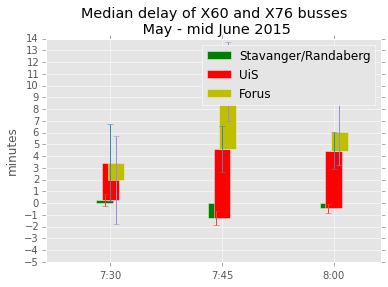

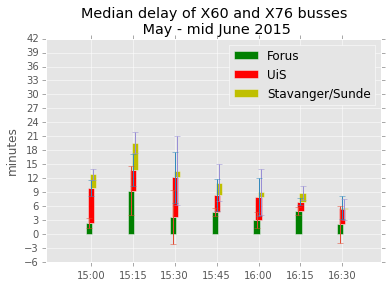

In [11]:
median_m = q0_m_f.groupby(q0_m_f.Astart.dt.time).median()
std_m = q0_m_f.groupby(q0_m_f.Astart.dt.time).describe().reset_index(). \
      set_index(['level_1', 'Astart']).loc['std']
median_m.La_e = median_m.La_e-median_m.La_m
median_m.La_m = median_m.La_m-median_m.La_s
median_m = median_m/60
std_m = std_m/60

plt.figure()
ind = np.arange(len(median_m))
width = 0.15
p1 = plt.bar(ind-0.05, median_m.La_s, width, color='g', yerr=std_m.La_s)
p2 = plt.bar(ind, median_m.La_m, width, color='r', 
             bottom=median_m.La_s,
             yerr=std_m.La_m)
p3 = plt.bar(ind+0.05, median_m.La_e, width, color='y', 
             bottom=median_m.La_s+median_m.La_m,
             yerr=std_m.La_e)
plt.ylabel('minutes')
plt.title('Median delay of X60 and X76 busses \n May - mid June 2015')
plt.xticks(ind + width/2., ('7:30', '7:45', '8:00', '8:15'))
plt.yticks(np.arange(-5, 15, 1))
plt.legend((p1[0], p2[0], p3[0]), ('Stavanger/Randaberg', 'UiS', 'Forus'))
plt.show()

median_a = q0_a_f.groupby(q0_a_f.Astart.dt.time).median()
std_a = q0_a_f.groupby(q0_a_f.Astart.dt.time).describe().reset_index(). \
      set_index(['level_1', 'Astart']).loc['std']
median_a.La_e = median_a.La_e-median_a.La_m
median_a.La_m = median_a.La_m-median_a.La_s
median_a = median_a/60
std_a = std_a/60

plt.figure()
ind = np.arange(len(median_a))
width = 0.15
p1 = plt.bar(ind-0.05, median_a.La_s, width, color='g', yerr=std_a.La_s)
p2 = plt.bar(ind, median_a.La_m, width, color='r', 
             bottom=median_a.La_s,
             yerr=std_a.La_m)
p3 = plt.bar(ind+0.05, median_a.La_e, width, color='y', 
             bottom=median_a.La_s+median_a.La_m,
             yerr=std_a.La_e)
plt.ylabel('minutes')
plt.title('Median delay of X60 and X76 busses \n May - mid June 2015')
plt.xticks(ind + width/2., ('15:00', '15:15', '15:30', '15:45', '16:00', 
                            '16:15', '16:30', '16:45'))
plt.yticks(np.arange(-6, 45, 3))
plt.legend((p1[0], p2[0], p3[0]), ('Forus', 'UiS', 'Stavanger/Sunde'))
plt.show()

Histograms of delays.

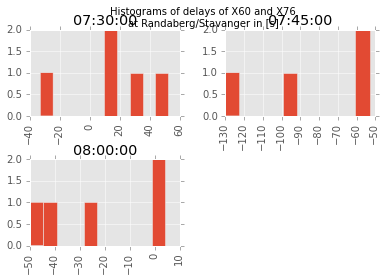

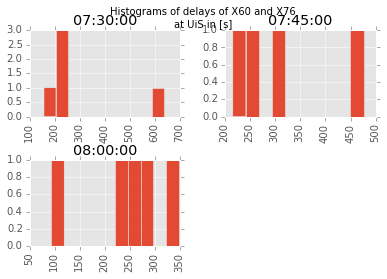

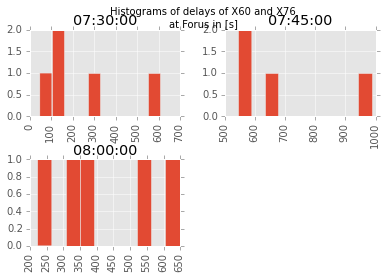

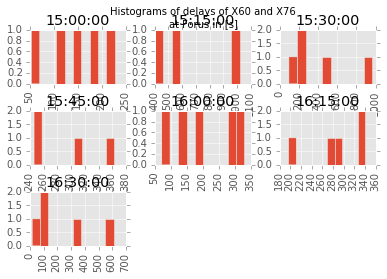

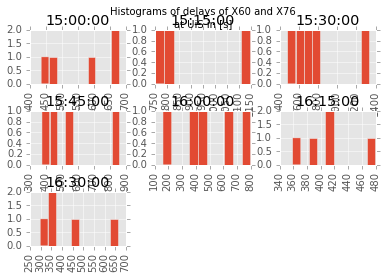

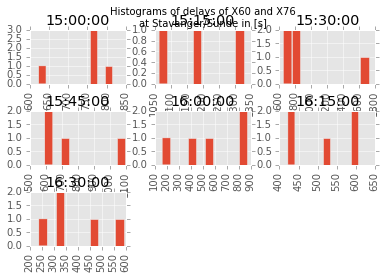

In [12]:
plt.figure()
q0_m_f.La_s.hist(by=q0_m_f.Astart.dt.time)
plt.suptitle('Histograms of delays of X60 and X76 \n' + \
             'at Randaberg/Stavanger in [s]')
plt.show()
plt.figure()
q0_m_f.La_m.hist(by=q0_m_f.Astart.dt.time)
plt.suptitle('Histograms of delays of X60 and X76 \n' + \
             'at UiS in [s]')
plt.show()
plt.figure()
q0_m_f.La_e.hist(by=q0_m_f.Astart.dt.time)
plt.suptitle('Histograms of delays of X60 and X76 \n' + \
             'at Forus in [s]')
plt.show()

plt.figure()
q0_a_f.La_s.hist(by=q0_a_f.Astart.dt.time)
plt.suptitle('Histograms of delays of X60 and X76 \n' + \
             'at Forus in [s]')
plt.show()
plt.figure()
q0_a_f.La_m.hist(by=q0_a_f.Astart.dt.time)
plt.suptitle('Histograms of delays of X60 and X76 \n' + \
             'at UiS in [s]')
plt.show()
plt.figure()
q0_a_f.La_e.hist(by=q0_a_f.Astart.dt.time)
plt.suptitle('Histograms of delays of X60 and X76 \n' + \
             'at Stavanger/Sunde in [s]')
plt.show()